<a href="https://www.assemblyai.com/">
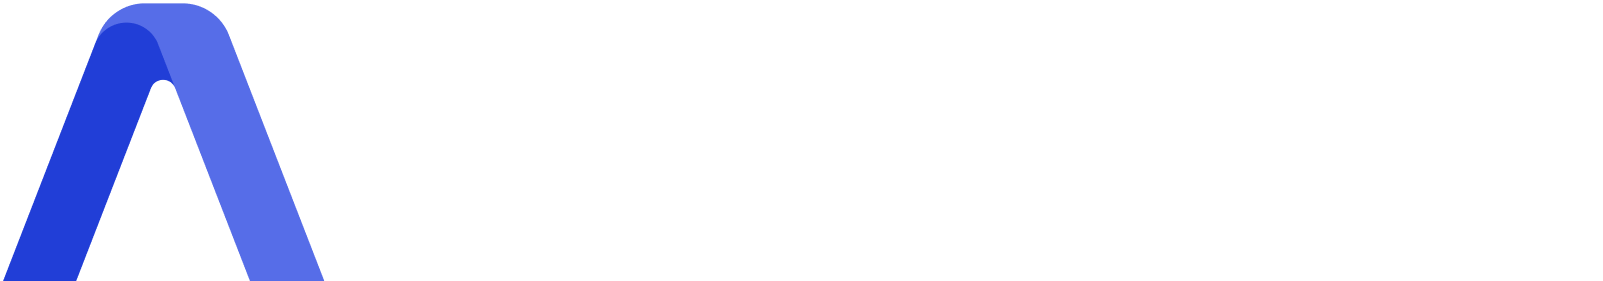
</a>
</img>

# Transcribing from an S3 Bucket

AssemblyAI's Speech-to-Text APIs can be used with both local files and publicly accessible online files, but what if you want to transcribe an audio file that has restricted access? Luckily, you can do this with AssemblyAI too!

Read on to learn how you can transcribe an audio file stored in an AWS S3 bucket using AssemblyAI's APIs.

## Intro

In order to transcribe an audio file from an S3 bucket, AssemblyAI will need temporary access to the file. To provide this access, we'll generate a **presigned URL**, which is simply a URL that has temporary access rights baked-in.

The overall process looks like this:
1. Generate a presigned URL for the S3 audio file with [boto](http://boto.cloudhackers.com/en/latest).
2. Pass this URL through to AssemblyAI's API with a POST request.
3. Wait until the transcription is complete, and then fetch it with a GET request.

## Prerequisites

First, you'll need an AssemblyAI account. You can sign up [here](https://app.assemblyai.com/signup) for a free account if you don't already have one.

Next, you'll need to **take note of your AssemblyAI API key**, which you can find on your [account dashboard](https://www.assemblyai.com/app/account) after signing in. It will be on the left-hand side of the screen under *Your API Key*.

You'll need the value of this key later, so leave the browser window open or copy the value into a text file.

## AWS IAM User

Second, you'll need an AWS IAM user with `Programmatic` access and the `AmazonS3ReadOnlyAccess` permission. If you already have such an IAM user and you know its public and private keys, then you can move on to the next section. Otherwise, create one now as follows:

First, log into AWS as a root user or as another IAM user with the appropriate access, and then go to the [IAM Management Console](https://us-east-1.console.aws.amazon.com/iamv2/home?ref=assemblyai.com#/users) to add a new user.

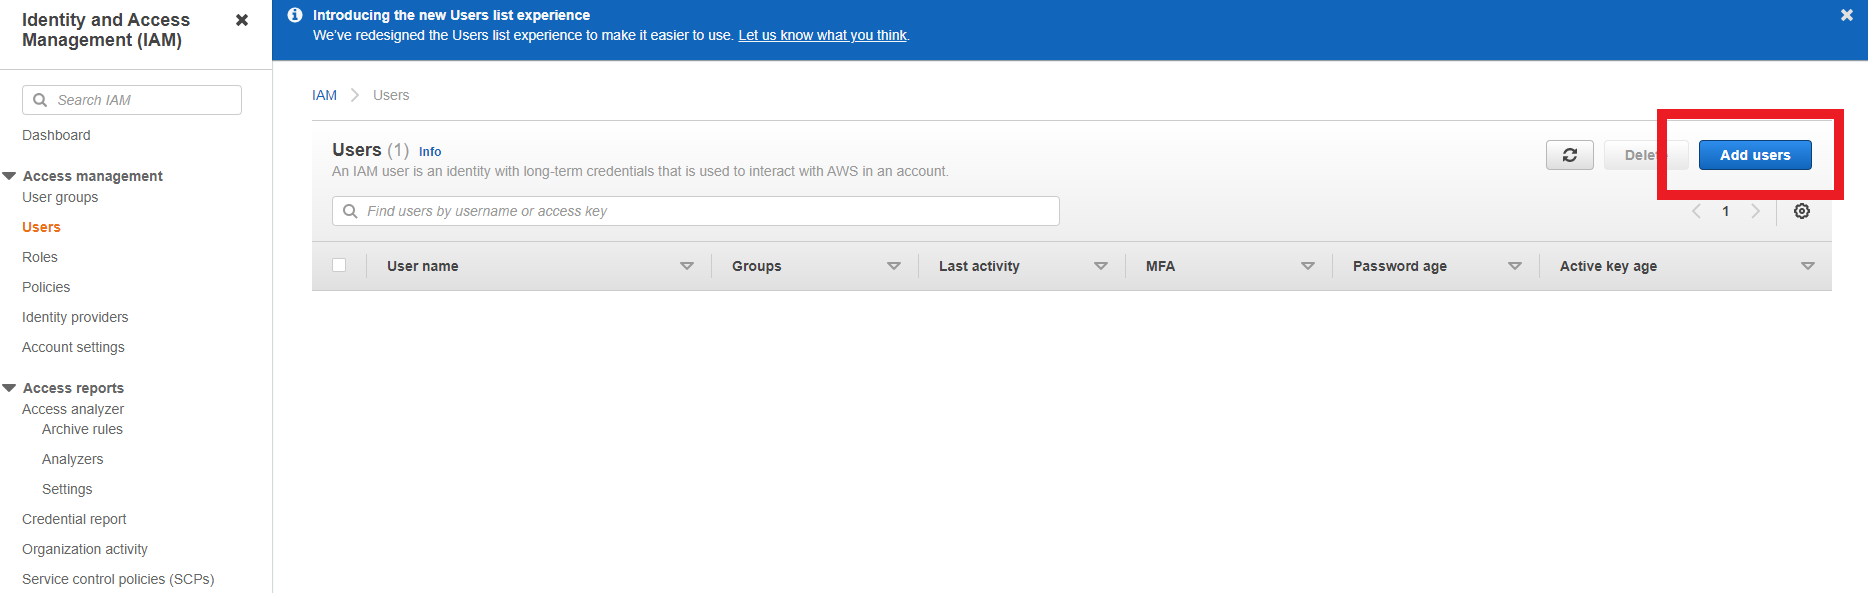

Set the user name you would like, and select *Programmatic access* under *Select AWS access type:*

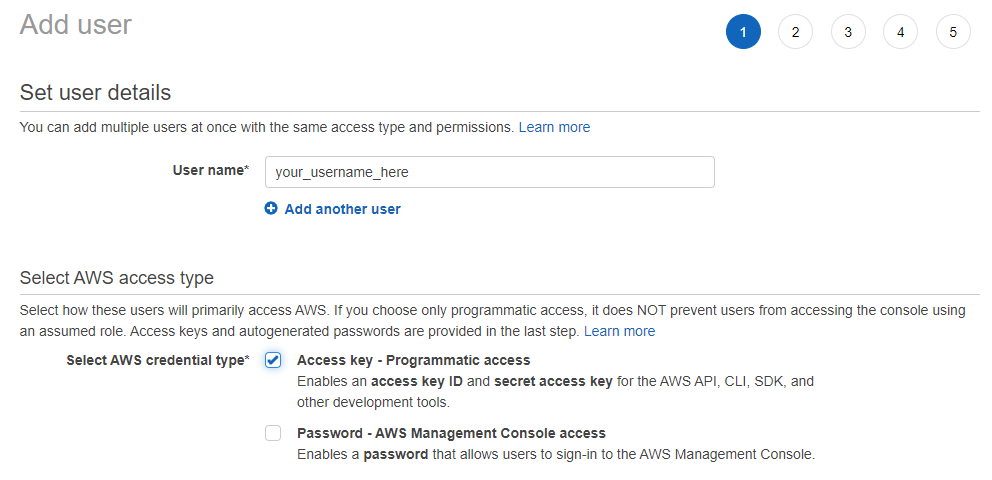

Click *Next*, and then *Attach existing policies directly*. Copy and paste *AmazonS3ReadOnlyAccess* into the *Filter policies* search box, and then add this permission by clicking on the checkbox next to it:

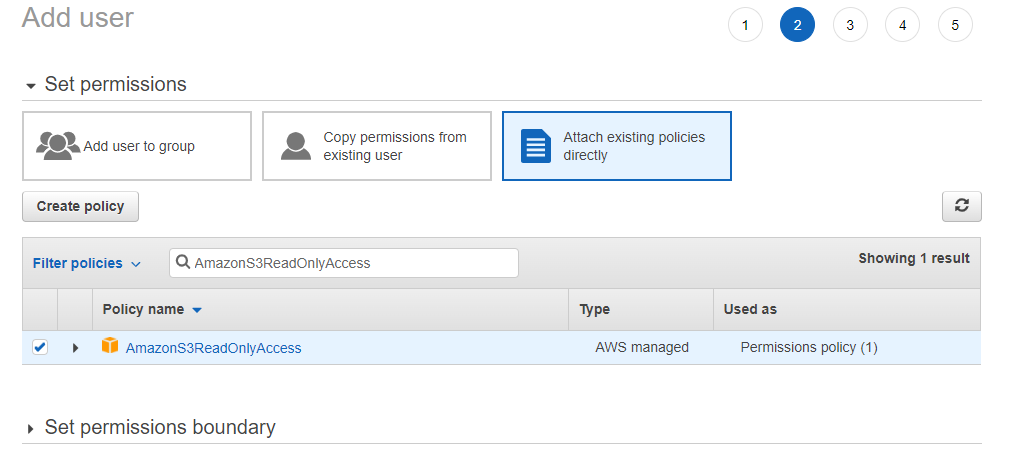

Click *Next* and add tags if you wish. Then click *Next* and review the IAM user profile to ensure that everything looks copacetic before clicking *Create user*.

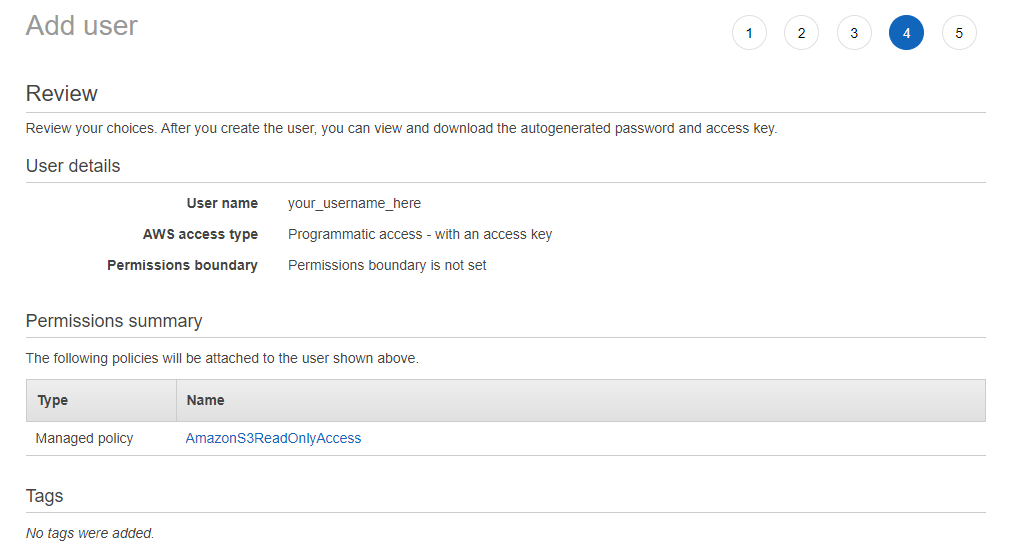

Finally, take note of the IAM user's *Access key ID* and *Secret access key*. Again, **we will need these values later**, so copy them into a text file before moving on.

**Warning**
Make sure to copy the IAM user's *Secret access key* and record it somewhere safe. Once you close the final window of the *Add user* sequence, you will not be able to access this key again and will need to regenerate it if you forget/lose the original.

## The Code

First, the necessary packages are installed.

In [ ]:
%pip install -U boto3 botocore

Then we can import them and set our relevant variable values. You'll need to edit these variables to be equivalent to the relevant values for your application:
1. `bucket_name` - The name of your AWS S3 bucket.
2. `object_name` - The name of the audio file in the S3 bucket that you want to transcribe.
3. `iam_access_id` - The access ID of the IAM user with programmatic access and S3 read permission.
4. `iam_secret_key` - The secret key of the IAM user.
5. `assembly_key` - Your AssemblyAI API key.

In [ ]:
import boto3
from botocore.exceptions import ClientError
import logging
import requests
import time

bucket_name = "<BUCKET_NAME>"
object_name = "<AUDIO_FILE_NAME>"

iam_access_id = "<IAM_ACCESS_ID>"
iam_secret_key = "<IAM_SECRET_KEY>"

assembly_key = "<ASSEMBLYAI_API_KEY>"

From here, we simply follow the sequence outlined in the introduction of this Colab:

1. Generate a presigned URL for the S3 audio file with [boto](http://boto.cloudhackers.com/en/latest).

In [ ]:
# Create a low-level service client with the IAM credentials.
s3_client = boto3.client(
    "s3", aws_access_key_id=iam_access_id, aws_secret_access_key=iam_secret_key
)

# Generate a pre-signed URL for the audio file that expires after 30 minutes.
try:
    p_url = s3_client.generate_presigned_url(
        ClientMethod="get_object",
        Params={"Bucket": bucket_name, "Key": object_name},
        ExpiresIn=1800,
    )

except ClientError as e:
    logging.error(e)

2. Pass the presigned URL through to AssemblyAI's API with a POST request.

In [ ]:
# Use your AssemblyAI API Key for authorization.
headers = {"authorization": assembly_key, "content-type": "application/json"}

# Specify AssemblyAI's transcription API endpoint.
upload_endpoint = "https://api.assemblyai.com/v2/transcript"

# Use the presigned URL as the `audio_url` in the POST request.
json = {"audio_url": p_url}

# Queue the audio file for transcription with a POST request.
post_response = requests.post(upload_endpoint, json=json, headers=headers)

3. Wait until the transcription is complete, and then fetch it with a GET request.

In [ ]:
# Specify the endpoint of the transaction.
get_endpoint = upload_endpoint + "/" + post_response.json()["id"]

# GET request the transcription.
get_response = requests.get(get_endpoint, headers=headers)

# If the transcription has not finished, wait util it has.
while get_response.json()["status"] != "completed":
    get_response = requests.get(get_endpoint, headers=headers)
    time.sleep(5)

# Once the transcription is complete, print it out.
print(get_response.json()["text"])